In [7]:
# Import các thư viện cần thiết
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

## 1. Load và chuẩn bị dữ liệu RFM

In [ ]:
# Load dữ liệu đã clean
df = pd.read_csv('../data/processed/cleaned_uk_data.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(f"📊 Số giao dịch: {len(df):,}")
print(f"👤 Số khách hàng: {df['CustomerID'].nunique():,}")
df.head()

In [ ]:
# Tính RFM cho mỗi khách hàng
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print(f"\n📊 RFM DataFrame shape: {rfm.shape}")
rfm.describe()

In [ ]:
# Chuẩn hóa dữ liệu (StandardScaler)
X = rfm[['Recency', 'Frequency', 'Monetary']].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"✅ Dữ liệu đã chuẩn hóa: {X_scaled.shape}")
print(f"   Mean: {X_scaled.mean(axis=0).round(4)}")
print(f"   Std:  {X_scaled.std(axis=0).round(4)}")

---
## 2. 🔧 Implement K-Means từ đầu

### Thuật toán K-Means:
1. **Khởi tạo:** Chọn K điểm ngẫu nhiên làm centroids
2. **Assign:** Gán mỗi điểm vào cluster có centroid gần nhất
3. **Update:** Tính lại centroid = trung bình các điểm trong cluster
4. **Repeat:** Lặp lại bước 2-3 cho đến khi hội tụ

In [ ]:
class KMeansFromScratch:
    """
    K-Means Clustering implemented from scratch using NumPy.
    
    Parameters:
    -----------
    n_clusters : int
        Số lượng clusters (K)
    max_iters : int
        Số vòng lặp tối đa
    tol : float
        Ngưỡng hội tụ (nếu centroids thay đổi < tol thì dừng)
    random_state : int
        Seed cho random (để reproducible)
    """
    
    def __init__(self, n_clusters=3, max_iters=100, tol=1e-4, random_state=42):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol
        self.random_state = random_state
        
        # Attributes sau khi fit
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None
        self.n_iters_ = 0
    
    def _euclidean_distance(self, X, centroids):
        """
        Tính khoảng cách Euclidean từ mỗi điểm đến mỗi centroid.
        
        X: (n_samples, n_features)
        centroids: (n_clusters, n_features)
        
        Returns: (n_samples, n_clusters) - distance matrix
        """
        # Broadcasting: X[:, np.newaxis] shape = (n_samples, 1, n_features)
        # centroids shape = (n_clusters, n_features)
        # Kết quả: (n_samples, n_clusters, n_features) -> sum -> (n_samples, n_clusters)
        distances = np.sqrt(((X[:, np.newaxis] - centroids) ** 2).sum(axis=2))
        return distances
    
    def _init_centroids(self, X):
        """
        Khởi tạo centroids bằng cách chọn ngẫu nhiên K điểm từ dữ liệu.
        """
        np.random.seed(self.random_state)
        n_samples = X.shape[0]
        random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        centroids = X[random_indices]
        return centroids
    
    def _assign_clusters(self, X, centroids):
        """
        Gán mỗi điểm vào cluster có centroid gần nhất.
        """
        distances = self._euclidean_distance(X, centroids)
        labels = np.argmin(distances, axis=1)
        return labels
    
    def _update_centroids(self, X, labels):
        """
        Cập nhật centroids = trung bình các điểm trong mỗi cluster.
        """
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                new_centroids[k] = cluster_points.mean(axis=0)
            else:
                # Nếu cluster rỗng, giữ nguyên centroid cũ hoặc random mới
                new_centroids[k] = self.centroids[k]
        return new_centroids
    
    def _compute_inertia(self, X, labels, centroids):
        """
        Tính inertia = tổng bình phương khoảng cách từ điểm đến centroid.
        (Within-Cluster Sum of Squares - WCSS)
        """
        inertia = 0
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                inertia += ((cluster_points - centroids[k]) ** 2).sum()
        return inertia
    
    def fit(self, X):
        """
        Fit K-Means model.
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
        
        Returns:
        --------
        self
        """
        # Bước 1: Khởi tạo centroids
        self.centroids = self._init_centroids(X)
        
        # Lặp
        for i in range(self.max_iters):
            # Bước 2: Assign clusters
            labels = self._assign_clusters(X, self.centroids)
            
            # Bước 3: Update centroids
            new_centroids = self._update_centroids(X, labels)
            
            # Kiểm tra hội tụ
            centroid_shift = np.sqrt(((new_centroids - self.centroids) ** 2).sum())
            
            self.centroids = new_centroids
            self.n_iters_ = i + 1
            
            if centroid_shift < self.tol:
                print(f"   ✅ Hội tụ sau {self.n_iters_} iterations (shift = {centroid_shift:.6f})")
                break
        
        # Final assignment và inertia
        self.labels_ = self._assign_clusters(X, self.centroids)
        self.inertia_ = self._compute_inertia(X, self.labels_, self.centroids)
        
        return self
    
    def predict(self, X):
        """
        Predict cluster cho dữ liệu mới.
        """
        return self._assign_clusters(X, self.centroids)
    
    def fit_predict(self, X):
        """
        Fit và trả về labels.
        """
        self.fit(X)
        return self.labels_


print("✅ KMeansFromScratch class defined!")

---
## 3. 🧪 Test K-Means từ đầu

In [ ]:
# Test với K=3
print("🔄 Chạy K-Means từ đầu với K=3...")
kmeans_scratch = KMeansFromScratch(n_clusters=3, max_iters=100, random_state=42)
labels_scratch = kmeans_scratch.fit_predict(X_scaled)

print(f"\n📊 Kết quả:")
print(f"   Số iterations: {kmeans_scratch.n_iters_}")
print(f"   Inertia (WCSS): {kmeans_scratch.inertia_:.2f}")
print(f"   Silhouette Score: {silhouette_score(X_scaled, labels_scratch):.4f}")
print(f"\n   Phân bố clusters:")
for i in range(3):
    count = (labels_scratch == i).sum()
    print(f"   - Cluster {i}: {count} khách ({count/len(labels_scratch)*100:.1f}%)")

---
## 4. 📊 So sánh với sklearn

In [ ]:
from sklearn.cluster import KMeans

# Sklearn K-Means
print("🔄 Chạy sklearn KMeans với K=3...")
kmeans_sklearn = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_sklearn = kmeans_sklearn.fit_predict(X_scaled)

print(f"\n📊 So sánh kết quả:")
print(f"{'Metric':<25} {'From Scratch':<15} {'sklearn':<15}")
print("-" * 55)
print(f"{'Iterations':<25} {kmeans_scratch.n_iters_:<15} {kmeans_sklearn.n_iter_:<15}")
print(f"{'Inertia':<25} {kmeans_scratch.inertia_:<15.2f} {kmeans_sklearn.inertia_:<15.2f}")
print(f"{'Silhouette':<25} {silhouette_score(X_scaled, labels_scratch):<15.4f} {silhouette_score(X_scaled, labels_sklearn):<15.4f}")

---
## 5. 📈 Tìm K tối ưu (Elbow + Silhouette)

In [ ]:
# Thử nhiều giá trị K
K_range = range(2, 11)
inertias = []
silhouettes = []

print("🔄 Thử K từ 2 đến 10...\n")
for k in K_range:
    print(f"K = {k}:", end=" ")
    km = KMeansFromScratch(n_clusters=k, max_iters=100, random_state=42)
    labels = km.fit_predict(X_scaled)
    
    inertias.append(km.inertia_)
    sil = silhouette_score(X_scaled, labels)
    silhouettes.append(sil)
    print(f"Inertia = {km.inertia_:.2f}, Silhouette = {sil:.4f}")

print(f"\n🏆 K tối ưu (theo Silhouette): K = {K_range[np.argmax(silhouettes)]}")

In [ ]:
# Vẽ biểu đồ Elbow và Silhouette
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Số clusters (K)', fontsize=12)
axes[0].set_ylabel('Inertia (WCSS)', fontsize=12)
axes[0].set_title('📉 Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette plot
colors = ['red' if s == max(silhouettes) else 'steelblue' for s in silhouettes]
axes[1].bar(K_range, silhouettes, color=colors, edgecolor='black')
axes[1].set_xlabel('Số clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('📊 Silhouette Score', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 1)
axes[1].grid(True, alpha=0.3, axis='y')

# Highlight best K
best_k = K_range[np.argmax(silhouettes)]
axes[1].axvline(x=best_k, color='red', linestyle='--', linewidth=2, label=f'Best K = {best_k}')
axes[1].legend()

plt.tight_layout()
plt.savefig('../data/processed/kmeans_scratch_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Saved: data/processed/kmeans_scratch_evaluation.png")

---
## 6. 🎨 Visualize Clusters (PCA)

In [ ]:
from sklearn.decomposition import PCA

# Chạy với K tối ưu
best_k = K_range[np.argmax(silhouettes)]
print(f"🔄 Chạy K-Means với K = {best_k}...")
kmeans_final = KMeansFromScratch(n_clusters=best_k, max_iters=100, random_state=42)
labels_final = kmeans_final.fit_predict(X_scaled)

# PCA giảm về 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"\n📊 PCA Explained Variance:")
print(f"   PC1: {pca.explained_variance_ratio_[0]*100:.1f}%")
print(f"   PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")
print(f"   Total: {pca.explained_variance_ratio_.sum()*100:.1f}%")

In [ ]:
# Vẽ scatter plot
plt.figure(figsize=(12, 8))

# Transform centroids to PCA space
centroids_pca = pca.transform(kmeans_final.centroids)

# Colors
colors = plt.cm.Set1(np.linspace(0, 1, best_k))

for i in range(best_k):
    mask = labels_final == i
    count = mask.sum()
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                c=[colors[i]], label=f'Cluster {i} (n={count})',
                alpha=0.6, s=50, edgecolors='white', linewidth=0.5)

# Plot centroids
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
            c='black', marker='X', s=300, edgecolors='white', linewidth=2,
            label='Centroids', zorder=5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
plt.title(f'🎯 K-Means Clustering (K={best_k}) - From Scratch\nSilhouette = {silhouettes[best_k-2]:.4f}', 
          fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/processed/kmeans_scratch_pca.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Saved: data/processed/kmeans_scratch_pca.png")

---
## 7. 📋 Phân tích Clusters

In [ ]:
# Thêm labels vào RFM dataframe
rfm['Cluster'] = labels_final

# Thống kê theo cluster
cluster_stats = rfm.groupby('Cluster').agg({
    'CustomerID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(2)

cluster_stats.columns = ['Count', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary']
cluster_stats['Percentage'] = (cluster_stats['Count'] / cluster_stats['Count'].sum() * 100).round(1)

print("📊 Thống kê theo Cluster:")
print("=" * 70)
cluster_stats

In [ ]:
# Đặt tên và persona cho mỗi cluster
def assign_segment_name(row):
    if row['Avg_Monetary'] > 5000 and row['Avg_Frequency'] > 10:
        return '🌟 VIP Champions'
    elif row['Avg_Recency'] < 50 and row['Avg_Frequency'] > 5:
        return '⭐ Loyal Customers'
    elif row['Avg_Recency'] < 100:
        return '💚 Active Customers'
    elif row['Avg_Recency'] > 200:
        return '⚠️ At Risk / Lost'
    else:
        return '📦 Regular Customers'

cluster_stats['Segment'] = cluster_stats.apply(assign_segment_name, axis=1)

print("\n🏷️ Phân loại Segments:")
print("=" * 80)
cluster_stats[['Count', 'Percentage', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Segment']]

---
## 8. 🎯 Tổng kết

In [ ]:
print("="*60)
print("🎯 TỔNG KẾT K-MEANS FROM SCRATCH")
print("="*60)
print(f"\n📊 Dữ liệu:")
print(f"   - Số khách hàng: {len(rfm):,}")
print(f"   - Features: Recency, Frequency, Monetary (RFM)")

print(f"\n⚙️ Thuật toán:")
print(f"   - K-Means implemented from scratch (NumPy only)")
print(f"   - Số clusters: K = {best_k}")
print(f"   - Số iterations đến hội tụ: {kmeans_final.n_iters_}")

print(f"\n📈 Kết quả:")
print(f"   - Silhouette Score: {silhouettes[best_k-2]:.4f}")
print(f"   - Inertia (WCSS): {kmeans_final.inertia_:.2f}")

print(f"\n✅ Files đã lưu:")
print(f"   - data/processed/kmeans_scratch_evaluation.png")
print(f"   - data/processed/kmeans_scratch_pca.png")
print("="*60)

#Bước 2: Khởi tạo ngẫu nhiên các tâm cụm 
Với số lượng tâm cụm k ngẫu nhiên, tạo 1 kích thước (k, n_features) lưu các tâm cụm

In [1]:
# Hàm khởi tạo các tâm cụm ban đầu
def init_centroids(X, k):
    # Lấy số lượng mẫu và số lượng đặc trưng từ dữ liệu 
    n_samples, n_features = X.shape
    # Khởi tạo mảng centroids có kích thước (k, n_features)
    centroids = np.zeros((k, n_features))
    for i in range(k):
        # Chọn ngẫu nhiên một điểm dữ liệu làm tâm cụm
        centroid = X[np.random.choice(range(n_samples))]
        # Gán điểm dữ liệu vừa chọn làm tâm cụm thứ i
        centroids[i] = centroid
    # Trả về mảng các gía trị tâm cụm
    return centroids

# Bước 3: Gán mỗi điểm dữ liệu vào trung tâm cụm gần nhất
Tính toán khoảng cách từ mỗi điểm dữ liệu đến các tâm cụm, sau đó so sánh lấy giá trị nhỏ nhất của khoảng cách --> gán điểm dữ liệu vào tâm cụm 

In [2]:
# Gán mỗi điểm dữ liệu vào tâm cụm gần nhất
def closest_centroid(X, centroids):
    # Tính khoảng cách từ mỗi điểm dữ liệu đến các tâm cụm
    distance = cdist(X, centroids, 'euclidean')
    # Trả về chỉ số tâm cụm gần nhất cho từng điểm dữ liệu
    return np.argmin(distance, axis=1)

# Bước 4: Cập nhật lại tâm cụm mới
Tâm cụm mới được tính bằng trung bình cộng của các điểm trong cụm

In [3]:
# Cập nhật tâm cụm
def update_centroids(X, labels, k):
    # Lấy số lượng đặc trưng từ dữ liệu X
    n_features = X.shape[1]
    # Khởi tạo mảng centroids có kích thước (k, n_features) với các giá trị ban đầu là 0
    centroids = np.zeros((k, n_features))
    for i in range(k):
        # Lấy các điểm dữ liệu thuộc cụm thứ i
        points = X[labels == i]
        if len(points) > 0:
        # Tính trung bình các điểm dữ liệu thuộc cụm thứ i và gán giá trị này làm tâm cụm mới
            centroids[i] = points.mean(axis=0)
    # Trả về mảng chứa các tâm cụm đã được cập nhật
    return centroids

In [ ]:
# Thuật toán Kmeans hoàn chỉnh

In [5]:
# Định nghĩa hàm kmeans
def kmeans(X, k, max_iters=100):
    # Khởi tạo các tâm cụm ban đầu
    centroids = init_centroids(X, k)
    # Lặp tối đa max_iters
    for _ in range(max_iters):
        # Gán mỗi điểm dữ liệu vào cụm gần nhất
        labels = closest_centroid(X, centroids)
        # Cập nhật các tâm cụm
        new_centroids = update_centroids(X, labels, k)
        # Kiểm tra xem các tâm cụm có thay đổi hay không, nếu không đổi dừng vòng lặp
        if np.all(centroids == new_centroids):
            break
        # Cập nhật các tâm cụm mới
        centroids = new_centroids
    # Trả về các tâm cụm và nhãn của các điểm dữ liệu
    return centroids, labels

C:\Users\nguye\AppData\Local\Temp\ipykernel_17196\1721156980.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/cleaned_uk_data.csv', parse_dates=['InvoiceDate'])


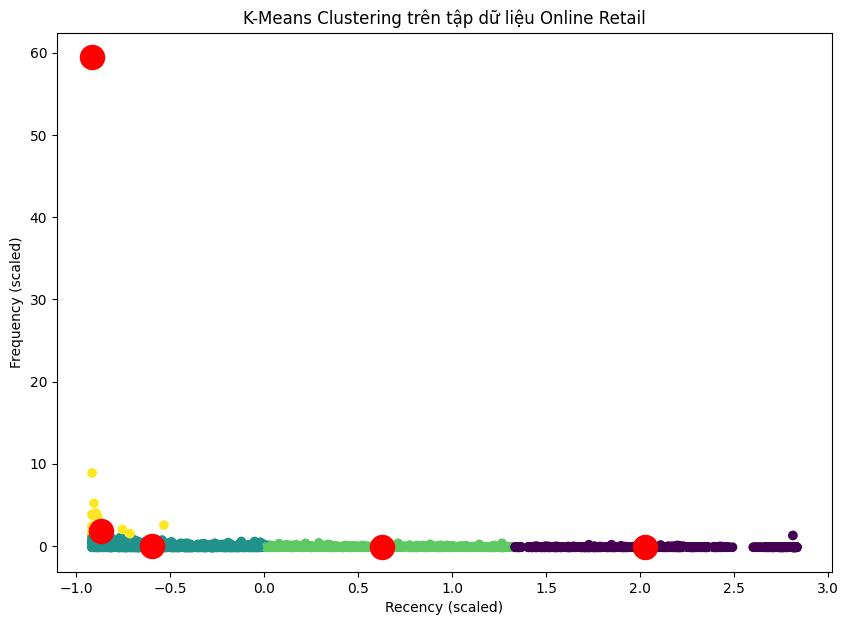

In [8]:
# Áp dụng K-Means trên tập dữ liệu Online Retail

# Nạp dữ liệu 
df = pd.read_csv('../data/processed/cleaned_uk_data.csv', parse_dates=['InvoiceDate'])

# Tạo đặc trưng RFM
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
X = rfm[['Recency', 'Frequency', 'Monetary']].values

# Chuẩn hoá dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Áp dụng Kmeans
k = 5
# Áp dụng thuật toán Kmeans để tìm các tâm cụm và nhãn của các điểm dữ liệu
centroids, labels = kmeans(X_scaled, k)

# Hiển thị kết quả phân cụm
plt.figure(figsize=(10, 7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red')
plt.xlabel('Recency (scaled)')
plt.ylabel('Frequency (scaled)')
plt.title('K-Means Clustering trên tập dữ liệu Online Retail')
plt.show()

